# Wikipedia Detox Data - Getting Started

This notebook gives an introduction to working with the [Wikipedia
Detox data release](https://doi.org/10.6084/m9.figshare.4054689). The release includes 100k labeled discussion comments from English Wikipedia. Each comment was labeled by multiple annotators via CrowdFlower on whether it contains 1) a personal attack and 2) conveys aggressive tone. In addition to the crowd-annotated data, we provide a corpus of comments from 2015 that were scored by a machine learning model trained on the crowd-annotated data. See our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each file and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology.

In this notebook we show how to build a simple classifier for detecting personal attacks using crowd-annotated data and give an example of how the corpus of model-annotated data can be used for analysis.

# Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier on crowd-annotated data.

In [1]:
# load annotated comments and annotations
import pandas as pd
comments = pd.read_csv('crowd_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('crowd_annotations.tsv',  sep = '\t')

In [2]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('comment_id')['attack'].mean() > 0.5

In [3]:
# join labels and comments
comments['attack'] = labels
comments.query('attack').head()['comment']

comment_id
801279                   Iraq is not good  \n\n  USA is bad 
2702703    ____\nfuck off you little asshole. If you want...
4632658         i have a dick, its bigger than yours! hahaha
6545332     renault \n\nyou sad little bpy for driving a ...
6545351     renault \n\nyou sad little bo for driving a r...
Name: comment, dtype: object

In [4]:
# fit a simple text classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.958


In [5]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False], dtype=bool)

In [6]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

# Prevalence of personal attacks by namespace
In this section we use the full corpus of comments from 2015 to see if personal attacks are more common on user talk or article talk page discussions. In our paper we show that the model is not biased by namespace.

In [7]:
# load annotated comments and annotations
import pandas as pd
corpus = pd.read_csv('model_annotated_comments_2015.tsv', sep = '\t', index_col = 0)

In [8]:
# threshold model scores
corpus['attack'] = corpus['attack_score'] > 0.425 # see paper

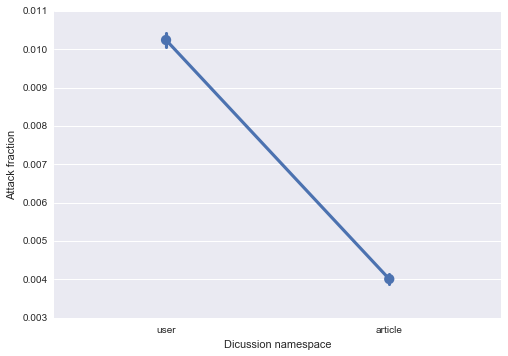

In [9]:
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")

Attacks are far more prevalent in the user talk namespace.